In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import seaborn
from getCitiBikeCSV import getCitiBikeCSV
import scipy.stats as sp

%pylab inline
'''
if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2016")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2016")
'''
import os
import json
#s = json.load( open(os.getenv('PUI2016') + "/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
datestring = '201506'
getCitiBikeCSV(datestring)
df = pd.read_csv(os.getenv('PUIDATA')+'/' + datestring + '-citibike-tripdata.csv')
df.head()

('Downloading', '201506')
file in place, you can continue


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984.0,1
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997.0,1
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993.0,1
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981.0,1
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0


## Idea: 
Men are more likely to bike after dark than women

## Null Hypothesis:
The ratio of men to women biking between the hours of 7pm-7am will be the same as or less than the ratio of men to women biking between 7am-7pm

$H_0$ : $\frac{M_{\mathrm{dark}}}{W_{\mathrm{dark}}} - \frac{M_{\mathrm{light}}}{W_{\mathrm{light}}} <= 0 $


$H_1$ : $\frac{M_{\mathrm{dark}}}{W_{\mathrm{dark}}} - \frac{M_{\mathrm{light}}}{W_{\mathrm{light}}} > 0$


I will use a significance level  $\alpha=0.05$
which means i want the probability of getting a result at least as significant as mine to be less then 5%.


I will be using data from a Citibike CSV file, detailing trips taken in May 2017

In [3]:
#df = df[::1000] #for testing purposes

df.drop(['tripduration', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year'], axis=1, inplace=True)
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df['time_of_day'] = np.round(((df.starttime.dt.hour + 1/60 * df.starttime.dt.minute) + (df.stoptime.dt.hour + 1/60 * df.stoptime.dt.minute))/2)
df['night'] = df['time_of_day'] > 19
df['morning'] = df['time_of_day'] < 7
df['dark'] = df['night'] + df['morning'] == 1
df.drop(['night', 'morning', 'starttime', 'stoptime'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


,gender,time_of_day,dark
0,1,0.0,True
1,1,0.0,True
2,1,0.0,True
3,1,0.0,True
4,0,0.0,True


**Note**<br>
Given that one may begin a ride at, for example, 6:50pm (which in our analysis is considered 'light,' and end at 10pm, actually spending the majority of their time biking in darkness, we chose to calculate the mean time for the trip, and round this to the nearest value. While the riding makes our answers less precise, there is no need for detailed percision in this instance, as those times are ballpark guesses to begin with, and the shift from light to dark is more gradual. That said, the middle point in a ride is a more accurate guess, in this instance, than either the start or end time, beacuse it takes duration into consideration. That said, it is not perfect, but should be sufficient for our purposes.

In [4]:
# Group by and get counts for men and women by hour
hours = pd.Series(range(0,24))
women = df.time_of_day[df.gender==2].\
        groupby(df['time_of_day']).count()
men   = df.time_of_day[df.gender==1].\
        groupby(df['time_of_day']).count()
dark = [True for i in range(0,24)]
for i in range (7,19):
    dark[i] = False

# Create dataframe with proper counts
hourly_data = pd.DataFrame(index=hours, columns=['men', 'women'])
hourly_data['women'] = women
hourly_data['men'] = men
hourly_data['ratio'] = men/women
hourly_data['dark'] = dark
hourly_data.dropna(inplace=True)
hourly_data

,men,women,ratio,dark
0,3240,637,5.086342,True
1,4777,1054,4.532258,True
2,2851,526,5.420152,True
3,1617,259,6.243243,True
4,1120,166,6.746988,True
5,1498,296,5.060811,True
6,8679,1717,5.054747,True
7,22820,5040,4.527778,False
8,41967,12254,3.424759,False
9,54507,18220,2.991603,False


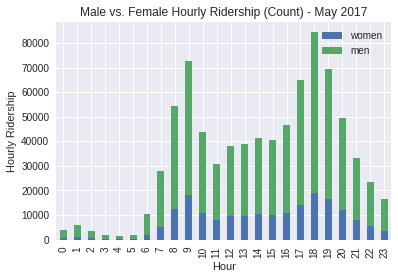

In [5]:
ax = hourly_data[['women', 'men']].plot(kind='bar', stacked=True)
ax.set_xlabel('Hour')
ax.set_ylabel('Hourly Ridership')
ax.set_title('Male vs. Female Hourly Ridership (Count) - May 2017')

**Figure 1:** We see that ridership tends to peak at commuting hours, particularly the morning, and that men tend to ride more than women, generally. This does not quite tell us if men are more likely to ride in the darker hours than women compared to their normal frequencies of riding more; to investigate this, we will need to further investigate the ratio of men to women riders over time.

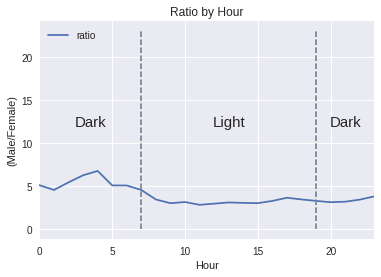

In [6]:
ax1 = hourly_data[['ratio']].plot()
plt.plot((7,7),(0,23),'--', color='lightslategrey')
plt.plot((19,19),(0,23),'--', color='lightslategrey')
ax1.text(13, 12, r'Light', fontsize=15, horizontalalignment='center')
ax1.text(3.5, 12, r'Dark', fontsize=15, horizontalalignment='center')
ax1.text(21, 12, r'Dark', fontsize=15, horizontalalignment='center')

ax1.set_title('Ratio by Hour')
ax1.set_ylabel('(Male/Female)')
ax1.set_xlabel('Hour')

**Figure 2:** Here we see a plotted ratio of men vs. women riding citibikes over the aggregated course of days in May 2017. It seems like there is ample evidence that men, while riding more frequently than women overall (this could be contributed to commuting or other motives, particularly tend to ride more when it is dark outside, especially in early mornings. While there is no formal requirement to reject the null hypothesis in this assignment, it does not seem like it would stand, given the evidence available here.

In [7]:
ratio_dark = hourly_data[hourly_data['dark']==True]['ratio']
ratio_light = hourly_data[hourly_data['dark']==False]['ratio']

In [11]:
sp.ttest_ind(ratio_dark, ratio_light)

Ttest_indResult(statistic=3.4220733515946202, pvalue=0.0024392880084942279)

**Conclusion**<br>
Both the graph (Figure 2) and low p-value (0.0024 compared to our 0.05 threshold) give strong reason to reject the null hypothesis in this case. Therefore, we are able to conclude that the ratio of men to women ridership is higher than women at night. More analysis is critical before any generalized conclusions are drawn, as this data is from only New York City, and for only one month. 